In [14]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
import torchvision
from torch import nn, autograd, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
from torch.autograd import grad
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [15]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [16]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
torch.cuda.is_available()

True

In [19]:
device_ids = [0]

In [20]:
BATCH_SIZE = 128
num_epochs = 100

z_dimension = 100
DIM = 56
num_feature = 56 * 56

In [21]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST('~/data/mnist', transform=img_transform) #, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [22]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [23]:
def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(1, 1, 1, 1)
    alpha = alpha.expand_as(real_data)
    alpha = alpha.to(device)
    
#     fake_data = fake_data.view(BATCH_SIZE, 3, DIM, DIM)
    interpolates = alpha * real_data.detach() + ((1 - alpha) * fake_data.detach())

    interpolates = interpolates.to(device)
    interpolates.requires_grad_(True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)                              
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
    return gradient_penalty

In [24]:
%%latex
\begin{array}
{ll}H_{out} = (H_{in} - 1) \times \text{stride}[0] - 2 \times \text{padding}[0] + \text{dilation}[0]
                    \times (\text{kernel_size}[0] - 1) + \text{output_padding}[0] + 1
\end{array}
\begin{array}
{ll}W_{out} = (W_{in} - 1) \times \text{stride}[1] - 2 \times \text{padding}[1] + \text{dilation}[1]
                    \times (\text{kernel_size}[1] - 1) + \text{output_padding}[1] + 1

\end{array}

<IPython.core.display.Latex object>

In [25]:
class SelfAttention(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim):
        super(SelfAttention,self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
        
    def forward(self, x):
        
        m_batchsize, C, width ,height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1) # B (N) C
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height) # B C (N)
        energy = torch.bmm(proj_query, proj_key) # transpose check
        attention = self.softmax(energy) # B (N) (N) 
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height) # B C N

        out = torch.bmm(proj_value, attention.permute(0, 2, 1)) # B C N
        out = out.view(m_batchsize, C, width, height) # B C W H
        
        out = self.gamma * out + x
        return out, attention

In [26]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(1, 256, 4, padding=1), dim=0),
            nn.LeakyReLU(.2, True),
            
#             nn.AvgPool2d(2, 2), 
        ) # b 32 28 28
        
        self.conv2 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(256, 128, 4, padding=1, stride=2), dim=0),
            nn.LeakyReLU(.2, True),
            
#             nn.AvgPool2d(2, 2), 
        ) # b 32 14 14
        
        self.conv3 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(128, 64, 4, padding=1, stride=2), dim=0),
            nn.LeakyReLU(.2, True),
#             nn.AvgPool2d(2, 2),
        ) # b 64 7 7
        
        self.conv4 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(64, 32, 4, padding=1, stride=2), dim=0),
            nn.LeakyReLU(.2, True),
#             nn.AvgPool2d(2, 2),
        ) # b 128 4 4
        
        self.conv5 = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(32, 1, 4, padding=1, stride=2), dim=0),
#             nn.LeakyReLU(.2, True),
#             nn.AvgPool2d(2, 2),
        ) # b 256 2 2
        
        self.att1 = SelfAttention(64)
        self.att2 = SelfAttention(32)
        
        self.last = nn.Sequential(
#             nn.Conv2d(64, 1, 2, padding=1, stride=2),
#             nn.Tanh()
#             nn.AvgPool2d(2, 2),
        ) # b 256 2 2
        
#         self.fc = nn.Sequential(
#             nn.utils.spectral_norm(nn.Linear(256 * 2 * 2, 1024), dim=0),
#             nn.LeakyReLU(.2, True),
#             nn.utils.spectral_norm(nn.Linear(1024, 1), dim=0),
#             nn.Sigmoid(),
# #             nn.Tanh(),
#         ) # b 1
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x): # b 1 28 28
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out, p1 = self.att1(out)
        out = self.conv4(out)
        out, p2 = self.att2(out)
        out = self.conv5(out)
        
        return out
#         print(out.shape)
#         return self.last(out)
        
#         out = out.view(x.size(0), -1)
#         return self.fc(out)

In [27]:
class Generator(nn.Module):
    def __init__(self, inp_dim, num_feature):
        super(Generator, self).__init__()
        
#         self.fc = nn.Sequential(
#             nn.Linear(inp_dim, num_feature),
#             nn.Sigmoid(),
#         ) # b h*w
#         self.br = nn.Sequential(
#             nn.BatchNorm2d(1),
#             nn.LeakyReLU(.2, True),
#         ) # b 1 56 56
        
#         self.downsample1 = nn.Sequential(
#             nn.utils.spectral_norm(nn.Conv2d(1, 16, 3, padding=1)),
# #             nn.BatchNorm2d(64),
#             nn.LeakyReLU(.2, True),
#         ) # b 64 56 56
        
#         self.downsample2 = nn.Sequential(
#             nn.utils.spectral_norm(nn.Conv2d(16, 8, 3, padding=1)),
#             nn.BatchNorm2d(8),
#             nn.LeakyReLU(.2, True),
#         ) # b 32 56 56
        
#         self.downsample3 = nn.Sequential(
#             nn.utils.spectral_norm(nn.Conv2d(8, 1, 3, padding=1, stride=2)),
#             nn.Tanh(),
#         ) # b 1 28 28
        
#         self.att1 = SelfAttention(16)
#         self.att2 = SelfAttention(8)
        
        self.upsample1 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(inp_dim, 1024, 4, 2, 1), dim=0),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
        ) # b c 2 2
        
        self.upsample2 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(1024, 512, 4, 2, 1), dim=0),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        ) # b c 4 4
        
        self.upsample3 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(512, 256, 4, 2, 1), dim=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        ) # b c 8 8
        
        self.upsample4 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(256, 128, 4, 2, 1), dim=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        ) # b c 16 16
        
        self.upsample5 = nn.Sequential(
            nn.utils.spectral_norm(nn.ConvTranspose2d(128, 1, 4, 2, 3), dim=0),
            nn.Tanh(),
        ) # b c 28 28
        
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(16, 1, 3, padding=1, stride=1),
#             nn.Tanh(),
#         )
        
        self.att1 = SelfAttention(256)
        self.att2 = SelfAttention(128)
        
        
        
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
            
    def forward(self, x):
#         out = self.fc(x)
        
#         out = out.view(x.size(0), 1, 56, 56)
#         out = self.br(out)
#         out = self.downsample1(out)
#         out, p1 = self.att1(out)
#         out = self.downsample2(out)
#         out, p2 = self.att2(out)
#         out = self.downsample3(out)
#         return out

        out = x.view(x.size(0), x.size(1), 1, 1)
        out = self.upsample1(out)
        out = self.upsample2(out)
        out = self.upsample3(out)
        out, p1 = self.att1(out)
        out = self.upsample4(out)
        out, p2 = self.att2(out)
        out = self.upsample5(out)
#         out = self.conv1(out)
        
        return out
        
        


In [28]:
d = Discriminator().to(device)
g = Generator(z_dimension, num_feature).to(device)

# d.weight_init(.0, 0.02)
# g.weight_init(.0, 0.02)

d = nn.DataParallel(d, device_ids=device_ids).to(device)
g = nn.DataParallel(g, device_ids=device_ids).to(device)

# criterion = nn.BCELoss()

d_optimezer = optim.Adam(d.parameters(), lr=2e-4, betas=(0, 0.9))
g_optimezer = optim.Adam(g.parameters(), lr=1e-4, betas=(0, 0.9))

one = torch.FloatTensor([1])
mone = one * -1
one = one.to(device)
mone = mone.to(device)

In [29]:
writer = SummaryWriter('./log/cnn_wgan_gp_self_attention')

In [30]:
img_path = "save_images/cnn_wgan_img_self_attention"
if not os.path.exists(img_path): os.makedirs(img_path)

In [ ]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    _step = epoch * total_count
    
    d_loss_total = .0
    g_loss_total = .0
    for i, (img, _) in enumerate(dataloader):
        
        ########## G ##########
        z = torch.randn(img.size(0), z_dimension).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        g_loss = -fake_out.mean()
        
        g_optimezer.zero_grad()
#         g_loss.backward(mone)
        g_loss.backward()
#         g_loss = -g_loss
        g_optimezer.step()
        #######################
        
        ########## D ##########
        real_img = img.cuda()
        
        real_out = d(real_img)
        d_loss_real = -real_out.mean()
        real_scores = real_out
        
#         z = torch.randn(img.size(0), z_dimension).cuda()
#         fake_img = g(z) # .detach()
        fake_out = d(fake_img.detach())
        d_loss_fake = fake_out.mean()
        fake_scores = fake_out
        
        gradient_penalty = calc_gradient_penalty(d, real_img, fake_img)
        
        d_loss = d_loss_fake + d_loss_real + gradient_penalty
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        #######################
        
        w_dist = d_loss_fake + d_loss_real
        
        d_loss_total += d_loss.item() * img.size(0)
        g_loss_total += g_loss.item() * img.size(0)
        
        step = _step + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
            writer.add_scalar('Wasserstein Distance', w_dist.item(), step)
        
        
        if (i + 1) % 300 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}' \
', fake_scores: {:.6f}, w: {:.6f}'.format(epoch+1, num_epochs, (i+1) * BATCH_SIZE, d_loss, g_loss, real_scores.mean(), fake_scores.mean(), w_dist))
    
    
    setp = (epoch + 1) * total_count
    _d_loss_total = d_loss_total / (total_count * (epoch + 1))
    _g_loss_total = g_loss_total / (total_count * (epoch + 1))
    
    writer.add_scalar('Discriminator Total Loss', _d_loss_total, step)
    writer.add_scalar('Generator Total Loss', _g_loss_total, step)
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}".format(epoch+1, 
                                                                             num_epochs, 
                                                                             _d_loss_total,
                                                                             _g_loss_total, ))
    
    writer.add_image('Generator Image', make_grid(fake_img.view(-1, 1, 28, 28).cpu().data, normalize=True, scale_each=True), step)
    
    if epoch == 0:
        real_images = real_img.view(-1, 1, 28, 28).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))
    
    
    
    fake_images = fake_img.view(-1, 1, 28, 28).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{}.png'.format(epoch+1)))

Epoch [1/100], Step:  38400, d_loss: -34.284397, g_loss: -73.285538, real_scores: 113.102730, fake_scores: 72.867920, w: -40.234810
Finish Epoch [1/100], D Loss: -2908.823459, G Loss: -6267.663133
Epoch [2/100], Step:  38400, d_loss: -23.813042, g_loss: -85.591415, real_scores: 121.378792, fake_scores: 85.492096, w: -35.886696
Finish Epoch [2/100], D Loss: -1700.356222, G Loss: -4993.661018
Epoch [3/100], Step:  38400, d_loss: -25.509462, g_loss: -71.440811, real_scores: 104.580200, fake_scores: 70.717636, w: -33.862564
Finish Epoch [3/100], D Loss: -1137.272798, G Loss: -3719.432416
Epoch [4/100], Step:  38400, d_loss: -25.262541, g_loss: -79.942894, real_scores: 109.468872, fake_scores: 79.793770, w: -29.675102
Finish Epoch [4/100], D Loss: -865.724132, G Loss: -2783.184107
Epoch [5/100], Step:  38400, d_loss: -28.186220, g_loss: -70.904655, real_scores: 100.221939, fake_scores: 70.891418, w: -29.330521
Finish Epoch [5/100], D Loss: -692.586146, G Loss: -2144.079284
Epoch [6/100], St

In [18]:
writer.close()

In [19]:
torch.save(d.state_dict(), './ser/wgan_gp_discriminator.pt')
torch.save(g.state_dict(), './ser/wgan_gp_generator.pt')

In [20]:
d.load_state_dict(torch.load('./ser/wgan_gp_discriminator.pt'))
g.load_state_dict(torch.load('./ser/wgan_gp_generator.pt'))

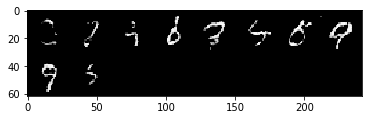

In [23]:
z = torch.randn(10, z_dimension).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()